# Analyse Statistique

### 1. Imports

In [8]:
# --------------------------------------------------------
# 0. Importations initiales
# --------------------------------------------------------
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
#import pingouin as pg  # <-- vous pouvez décommenter si vous voulez utiliser Pingouin
import matplotlib.pyplot as plt
import seaborn as sns

# Optionnel : configurations esthétiques
# plt.style.use('ggplot')   # par exemple, ou autre


## 1. Chargement et préparation des données

In [181]:
# Nom du dernier CSV
data_file = "SHS-Lie+detection+AI_April+9%2C+2025_11.22.csv"

df = pd.read_csv(data_file, header=0, skiprows=0)

# dictionnaire de correspondance pour les questions en français
questions = dict(zip(df.columns, df.iloc[0]))

# supprimer les 2 premières lignes (elles sont inutiles)
df = df[2:]

df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Education,Education.1,Origins,Q17,Q18,Q19,Q20,Q21,id,Source
2,2025-03-04 13:08:42,2025-03-04 13:15:49,1,NaN,100,427,1,2025-03-04 13:15:50,R_8KoMYiS7pLDRnTb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-03-12 02:34:38,2025-03-12 02:35:28,1,NaN,100,50,1,2025-03-12 02:35:28,R_8htFlTMqyNsXx6x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-03-13 10:59:26,2025-03-13 11:03:14,1,NaN,100,228,1,2025-03-13 11:03:15,R_89aiCGR6g3QzEOd,NaN,...,2,gegvr,bgrsbs,2,1,2,3,1,NaN,NaN
5,2025-03-14 01:09:01,2025-03-14 01:09:26,0,185.12.130.88,76,24,0,2025-03-14 01:12:01,R_2qBCQkuA3CFDdud,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2025-04-02 04:07:37,2025-04-02 04:22:30,0,128.179.204.170,100,893,1,2025-04-02 04:22:31,R_8Do6YUFYQenUARY,NaN,...,5,Data science,France,5,5,"1,2,3,4,5,6,7,8,9,10",3,4,NaN,NaN


### Nettoyage / Filtrage

- Vérifier la cohérence des données.
- Supprimer ou identifier les valeurs manquantes ou aberrantes.
- Renommer les colonnes si nécessaire.


In [182]:
# garder seulement les questionnaires finis (à changer si trop peu de données)
df['Finished'] = df['Finished'].astype(int)
df = df.loc[df["Finished"]!=0]

# enlver les previews de test de notre part
df = df.loc[df["DistributionChannel"] == "anonymous"]

# supprimer les colones non pertinentes
df = df.drop(columns=["EndDate","Status","IPAddress","RecipientLastName","RecipientFirstName","RecipientEmail","ExternalReference","LocationLatitude","LocationLongitude"], axis=1)

# trouver si groupe texte ou audio, et mettre dans la colonne "subgroup"
df["feedback_type"]= df["conf. post 3 (t,NH)_1"].isna().apply(lambda x: "audio" if x else "text")

df.head()

,StartDate,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Consentement,Timer Video 1_First Click,...,Education.1,Origins,Q17,Q18,Q19,Q20,Q21,id,Source,feedback_type
6,2025-04-02 04:07:37,100,893,1,2025-04-02 04:22:31,R_8Do6YUFYQenUARY,anonymous,FR,1,1.785,...,Data science,France,5,5,"1,2,3,4,5,6,7,8,9,10",3,4,NaN,NaN,audio
7,2025-04-02 04:50:45,100,945,1,2025-04-02 05:06:30,R_3to1h0SPRWKMjoP,anonymous,FR,1,3.02,...,bac pro HPS,france,3,2,"1,2,3,4,5,6,7,8,9,10",2,3,NaN,NaN,audio
8,2025-04-02 04:56:20,100,822,1,2025-04-02 05:10:03,R_7YEYfnqKlBiEcLK,anonymous,FR,1,9.996,...,Sciences du vivant,France et Mexique,5,3,"1,2,3,4,5,6,7,8,10",1,3,NaN,NaN,audio
9,2025-04-02 06:28:01,100,2466,1,2025-04-02 07:09:09,R_5NFkJM20zBo2Fhf,anonymous,FR,1,10.201,...,Secrétariat,France,1,2,"2,3,5,7,8,9",1,3,NaN,NaN,text
10,2025-04-02 08:57:57,100,1496,1,2025-04-02 09:22:54,R_80NvFqnRsqG3Ofm,anonymous,FR,1,7.873,...,Coiffure,France,2,2,"1,2,3,4",1,3,NaN,NaN,audio


### Renommer les colonnes en minuscules et standardiser l'écriture

In [185]:
import re

# Step 1: Standardize column names
# Convert all to lowercase
df.columns = [col.lower() for col in df.columns]

# Standardize column names
new_columns = {}
for col in df.columns:
    # Start with the original lowercase column
    new_col = col
    
    # Replace various spellings and accents
    new_col = new_col.replace('initale', 'initiale').replace('initialle', 'initiale')
    new_col = new_col.replace('vérité', 'verite')
    
    # Replace spaces with underscores
    new_col = new_col.replace(' ', '_').replace('.', '').replace('__', '_').replace('*','')
    
    # Store mapping
    new_columns[col] = new_col

# Rename the dataframe columns
df_new = df.rename(columns=new_columns)

First 10 standardized column names:
Index(['startdate', 'progress', 'duration_(in_seconds)', 'finished',
       'recordeddate', 'responseid', 'distributionchannel', 'userlanguage',
       'consentement', 'timer_video_1_first_click'],
      dtype='object')


## Création d'un nouveau dataframe avec une ligne par question.

In [ ]:

# Initialize an empty list to store the restructured data
reshaped_data = []

# Process each participant
for _, row in df_new.iterrows():
    participant_id = row['responseid']
    feedback_type = row['feedback_type'] if 'feedback_type' in row else None
    
    # Process each of the 10 videos
    for video_num in range(1, 11):
        # Extract time spent on the video
        timer_base = f'timer_video_{video_num}'
        time_submit = np.round(float(row.get(f'{timer_base}_last_click', np.nan))-float(row.get(f'{timer_base}_first_click', np.nan)),1)
        time_on_video = time_submit  # Or calculate a difference if needed
        
        # Extract the initial guess and confidence
        # initial_guess_base = f'verite_initiale_{video_num}'
        
        # initial_guess = None
        # for suffix in ['', '_l', '_t']:
        #     if f'{initial_guess_base}{suffix}' in row:
        #         initial_guess = row[f'{initial_guess_base}{suffix}']
        #         if initial_guess is not None:
        #             break
                
        initial_guess_base = f'verite_initiale_{video_num}'
        matching_columns = [col for col in row.index if col.startswith(initial_guess_base)]
        initial_guess = row[matching_columns[0]]
                
        # Get initial confidence
        initial_conf_base = f'conf_initiale_{video_num}'
        matching_columns = [col for col in row.index if col.startswith(initial_conf_base)]
        initial_confidence = row[matching_columns[0]]
        
        
        # Determine if feedback was given as human or AI
        # Based on video number: odd -> NH, even -> H
        hum_AI = "H" if video_num % 2 == 0 else "NH"
        
        # Extract the responses based on feedback type
        # Simplified to search for base patterns
        
        # Base patterns for text and audio feedback columns
        text_base =  f'verite_post_{video_num}_(t'
        text_conf_base = f'conf_post_{video_num}_(t'
        text_influence_base = f'influence_{video_num}_(t'
        text_comment_base = f'qo_{video_num}_(t'
        
        audio_base = f'verite_post_{video_num}_(a'
        audio_conf_base = f'conf_post_{video_num}_(a'
        audio_influence_base = f'influence_{video_num}_(a'
        audio_comment_base = f'qo_{video_num}_(a'
        
        # Choose which set of base patterns to use based on feedback_type
        if feedback_type == 'text':
            later_guess_base = text_base
            later_confidence_base = text_conf_base
            influence_base = text_influence_base
            comment_base = text_comment_base
        else:  # Assuming 'audio'
            later_guess_base = audio_base
            later_confidence_base = audio_conf_base
            influence_base = audio_influence_base
            comment_base = audio_comment_base
        
        # Extract values by matching the base pattern with any column containing it
        def get_value_by_base_pattern(bases, row):
            matching_cols = [col for col in row.index if col.startswith(bases)]
            if matching_cols[0]:
                return row[matching_cols[0]]
            return None
        
        later_guess = get_value_by_base_pattern(later_guess_base, row)
        later_confidence = get_value_by_base_pattern(later_confidence_base, row)
        feedback_influence = get_value_by_base_pattern(influence_base, row)
        comments = get_value_by_base_pattern(comment_base, row)
        
        # Create a dictionary for this video
        video_data = {
            'participant_id': participant_id,
            'video_number': video_num,
            'feedback_type': feedback_type,
            'time_on_video': time_on_video,
            'initial_guess': initial_guess,
            'initial_confidence': initial_confidence,
            'later_guess': later_guess,
            'later_confidence': later_confidence,
            'feedback_influence': feedback_influence,
            'comments': comments,
            'hum_AI': hum_AI  # Add the new column
        }
        
        # Add to our list
        reshaped_data.append(video_data)
        
# Create the new DataFrame
new_df = pd.DataFrame(reshaped_data)

# Save to CSV
new_df.to_csv('reshaped_lie_detection_data.csv', index=False)

new_df.head(20)

,participant_id,video_number,feedback_type,time_on_video,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence,comments,hum_AI
0,R_8Do6YUFYQenUARY,1,audio,33.9,1,87,1,54,1,NaN,NH
1,R_8Do6YUFYQenUARY,2,audio,56.8,2,68,1,69,1,NaN,H
2,R_8Do6YUFYQenUARY,3,audio,32.2,1,64,1,62,1,NaN,NH
3,R_8Do6YUFYQenUARY,4,audio,18.9,2,85,2,68,1,NaN,H
4,R_8Do6YUFYQenUARY,5,audio,20.7,1,77,1,91,1,NaN,NH
5,R_8Do6YUFYQenUARY,6,audio,75.3,2,58,2,40,1,NaN,H
6,R_8Do6YUFYQenUARY,7,audio,23.1,1,74,1,87,1,NaN,NH
7,R_8Do6YUFYQenUARY,8,audio,24.2,1,88,1,93,1,NaN,H
8,R_8Do6YUFYQenUARY,9,audio,20.4,2,46,2,25,1,NaN,NH
9,R_8Do6YUFYQenUARY,10,audio,30.8,2,41,2,66,1,NaN,H


In [36]:
# Exemple (à adapter):
# df = df.dropna(subset=["participant_id", "accuracy_pre", "accuracy_post", "confidence_pre", "confidence_post"])

# Renommer si besoin
# df.rename(columns={
#     "old_colname_1": "accuracy_pre",
#     "old_colname_2": "accuracy_post",
#     ...
# }, inplace=True)

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 2 to 9
Columns: 170 entries, StartDate to Source
dtypes: object(170)
memory usage: 10.8+ KB


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Education,Education.1,Origins,Q17,Q18,Q19,Q20,Q21,id,Source
count,8,8,8,5,8,8,8,8,8,0,...,5,5,5,5,5,5,5,5,0,0
unique,8,8,2,5,2,8,2,8,8,0,...,3,5,4,4,4,4,3,3,0,0
top,2025-03-04 13:08:42,2025-03-04 13:15:49,0,185.12.130.88,100,427,1,2025-03-04 13:15:50,R_8KoMYiS7pLDRnTb,NaN,...,2,gegvr,France,5,2,"1,2,3,4,5,6,7,8,9,10",3,3,NaN,NaN
freq,1,1,5,1,7,1,7,1,1,NaN,...,3,1,2,2,2,2,2,3,NaN,NaN


## 2. Création des variables d'intérêt

Ici, on crée par exemple la différence de précision et de confiance (post - pré) pour chaque participant.


In [ ]:
# Supposez que df contient déjà accuracy_pre, accuracy_post, confidence_pre, confidence_post
df["accuracy_diff"] = df["accuracy_post"] - df["accuracy_pre"]
df["confidence_diff"] = df["confidence_post"] - df["confidence_pre"]

df.head()


## 3. Statistiques descriptives


In [4]:
# Statistiques descriptives globales
print(df[["accuracy_pre", "accuracy_post", "confidence_pre", "confidence_post"]].describe())

# Par groupe de Feedback Modality (Audio vs. Texte) et Feedback Source (Humain vs. IA)
group_stats = df.groupby(["feedback_modality", "feedback_source"])[["accuracy_pre","accuracy_post","confidence_pre","confidence_post"]].describe()
group_stats


NameError: name 'df' is not defined

### Visualisation (optionnel)

On peut faire quelques graphiques (histogrammes, boxplots) pour visualiser la distribution des variables et tester la normalité.


NameError: name 'df' is not defined

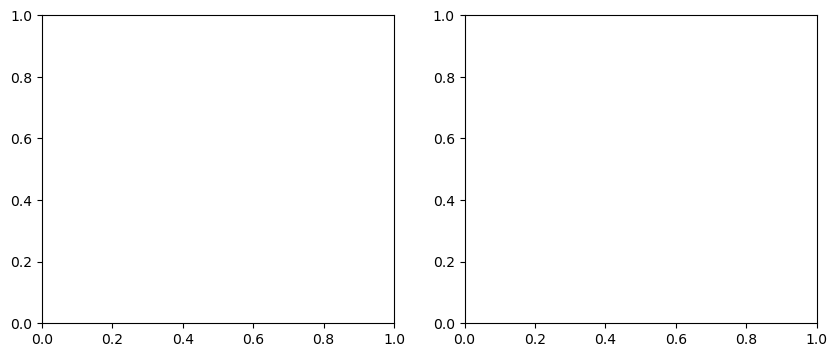

In [5]:
# Histograms
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(df["accuracy_diff"].dropna(), bins=10)
axes[0].set_title("Distribution accuracy_diff")

axes[1].hist(df["confidence_diff"].dropna(), bins=10)
axes[1].set_title("Distribution confidence_diff")

plt.show()


## 4. ANOVA mixte 2×2

Nous avons :
- Facteur intra-sujets : Feedback Source (Humain vs. IA)
- Facteur inter-sujets : Feedback Modality (Audio vs. Texte)
- Variable dépendante : par exemple *accuracy_diff* (et on fera la même chose pour *confidence_diff*).

### Option A : Avec Pingouin (Mixed ANOVA)


In [ ]:
# Exemple si vous utilisez pingouin.
# 1. Il faut avoir un format "long" :
#    Chaque participant apparaît dans 2 lignes (Humain vs. IA) pour la mesure within-subject
#    feedback_modality reste constant pour le participant.

# Démélangez ou "melt" si nécessaire. Supposez que vous avez une variable 'feedback_source' 
# déjà incrémentée sur chaque ligne. 
# Sinon, vous devez réorganiser le DataFrame (pivot_longer, etc.).

# Pour la démonstration seulement (pseudo-code):
"""
df_long = pd.melt(
    df, 
    id_vars=["participant_id", "feedback_modality"], 
    value_vars=["accuracy_diff_humain","accuracy_diff_IA"], 
    var_name="feedback_source", 
    value_name="accuracy_diff"
)
# feedback_source pourra être "humain" ou "IA" selon la colonne d'origine
# Ensuite:
anova_results = pg.mixed_anova(dv="accuracy_diff",
                               within="feedback_source",
                               between="feedback_modality",
                               subject="participant_id",
                               data=df_long)
print(anova_results)
"""


### Option B : Avec Statsmodels (MixedLM)

Il faut un modèle linéaire mixte, avec participant_id comme effet aléatoire (group).  
Vous pouvez également modéliser l’interaction.

*(La mise en forme dépend de la manière dont vos données sont structurées.)*


In [6]:
# Exemple très simplifié (vous devrez sans doute adapter le code et le format):
# Notons que dans Statsmodels, il faut coder feedback_source en 0/1 ou en variable catégorielle.

# Supposez que feedback_source (Humain vs. IA) et feedback_modality (Audio vs. Texte) 
# sont des colonnes du DF 'df_long' (chaque ligne = 1 participant × 1 condition).
# On va créer un modèle mixte:
"""
model = smf.mixedlm("accuracy_diff ~ feedback_source * feedback_modality", 
                    df_long, 
                    groups=df_long["participant_id"])
fit = model.fit()
print(fit.summary())
"""


'\nmodel = smf.mixedlm("accuracy_diff ~ feedback_source * feedback_modality", \n                    df_long, \n                    groups=df_long["participant_id"])\nfit = model.fit()\nprint(fit.summary())\n'

## 5. Comparaisons t-tests appariés (avant/après)


In [7]:
# Exemple : Comparer la confiance avant/après pour le groupe "audio"
audio_df = df[df["feedback_modality"] == "audio"].dropna(subset=["confidence_pre","confidence_post"])
t_stat, p_val = stats.ttest_rel(audio_df["confidence_pre"], audio_df["confidence_post"])
print(f"Groupe Audio - t={t_stat:.2f}, p={p_val:.4f}")

# Faire la même chose pour d'autres sous-groupes ou pour la variable accuracy_pre vs accuracy_post


NameError: name 'df' is not defined

## 6. Analyse qualitative des réponses ouvertes

Vous pouvez faire un premier aperçu en affichant les réponses, puis procéder à un codage manuel ou semi-automatisé.


In [ ]:
# Exemple : si la question ouverte est dans une colonne "open_response"
# On peut consulter les premières réponses
if "open_response" in df.columns:
    for idx, resp in enumerate(df["open_response"].dropna().head(10)):
        print(f"Participant {idx}: {resp}\n")


*(Ensuite, l’analyse approfondie peut se faire hors-ligne ou via un script dédié, 
avec par ex. des techniques de text-mining ou un codage thématique manuel.)*

---

## 7. Conclusion / Interprétation

- Interprétez les résultats des analyses (ANOVA, t-tests, etc.).
- Discutez des effets principaux, interactions et éventuels effets post hoc.
- Intégrez les thèmes émergents de l’analyse qualitative.

---
